#Exploring Climate Data: Past and Future
##Roland Viger, Rich Signell, USGS
First presented at the 2012 Unidata Workshop: Navigating Earth System Science Data, 9-13 July.

What if you were watching [Ken Burns's "The Dust Bowl"](http://www.pbs.org/kenburns/dustbowl/), saw the striking image below, and wondered: "How much precipitation there really was back in the dustbowl years?"  How easy is it to access and manipulate climate data in a scientific analysis?  Here we'll show some powerful tools that make it easy.


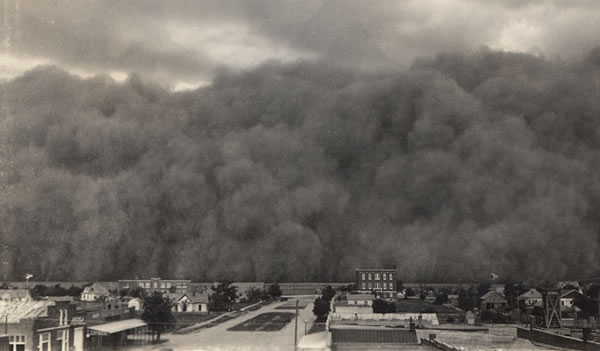

In [48]:
from IPython.core.display import Image
Image('http://www-tc.pbs.org/kenburns/dustbowl/media/photos/s2571-lg.jpg')

Above:Dust storm hits Hooker, OK, June 4, 1937. 

To find out how much rainfall was there during the dust bowl years, we can use the [USGS/CIDA GeoDataPortal (GDP)](http://cida.usgs.gov/climate/gdp/) which can compute statistics of a gridded field within specified shapes, such as county outlines.  Hooker is in Texas County, Oklahoma, so here we use the GDP to compute a historical time series of mean precipitation in Texas County using the PRISM dataset. We then compare to climate forecast projections to see if similar droughts are predicted to occur in the future, and what the impact of different climate scenarios might be. 

In [49]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import urllib
import os
from IPython.core.display import HTML
import time
import datetime
import pandas as pd
%matplotlib inline

In [50]:
import pyGDP
import numpy as np
import matplotlib.dates as mdates

In [51]:
import owslib
owslib.__version__

'0.9-dev'

In [52]:
pyGDP.__version__

'1.3.3'

One way to interface with the GDP is with the interactive web interface, shown below.  In this interface, you can upload a shapefile or draw on the screen to define a polygon region, then you specify the statistics and datasets you want to use via dropdown menus.  

In [53]:
HTML('<iframe src=http://screencast.com/t/K7KTcaFrSUc width=800 height=600></iframe>')

Here we use the python interface to the GDP, called PyGDP, which allows for scripting.  You can get the code and documentation at https://github.com/USGS-CIDA/pyGDP.

In [54]:
# Create a pyGDP object
myGDP = pyGDP.pyGDPwebProcessing()

DEBUG:owslib:http://cida.usgs.gov/gdp/process/WebProcessingService?version=1.0.0&request=GetCapabilities&service=WPS
DEBUG:owslib:<wps:Capabilities xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:wps="http://www.opengis.net/wps/1.0.0" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" service="WPS" version="1.0.0" xml:lang="en-US" xsi:schemaLocation="http://www.opengis.net/wps/1.0.0 http://schemas.opengis.net/wps/1.0.0/wpsGetCapabilities_response.xsd" updateSequence="1">
  <ows:ServiceIdentification>
    <ows:Title>Geo Data Portal WPS Processing</ows:Title>
    <ows:Abstract>Geo Data Portal WPS Processing</ows:Abstract>
    <ows:Keywords>
      <ows:Keyword>WPS</ows:Keyword>
      <ows:Keyword>AAFC</ows:Keyword>
      <ows:Keyword>geospatial</ows:Keyword>
      <ows:Keyword>geoprocessing</ows:Keyword>
    </ows:Keywords>
    <ows:ServiceType>WPS</ows:ServiceType>
    <ows:ServiceTypeVersion>1.0.0</ows:ServiceTypeVersion>
    <ows:ServiceTy

In [55]:
# Let's see what shapefiles are already available on the GDP server
# this changes with time, since uploaded shapefiles are kept for a few days
shapefiles = myGDP.getShapefiles()
print 'Available Shapefiles:'
for s in shapefiles:
    print s

Available Shapefiles:
upload:CIDA_TEST_
draw:hydrology
upload:HUC_Kert
sample:Alaska
sample:simplified_HUC8s
upload:Nodaway
upload:climdivisions
sample:CONUS_states
upload:OKCNTYD
derivative:wbdhu8_alb_simp
derivative:CONUS_States
draw:chdreahydrology
upload:testUpload
sample:CSC_Boundaries
sample:FWS_LCC
derivative:NCA_Regions
derivative:Level_III_Ecoregions
draw:TestArea
derivative:FWS_LCC
derivative:US_Counties
sample:CONUS_Climate_Divisions
upload:HUC_CHD
sample:nps_boundary_2013


In [56]:
# Is our shapefile there already?
# If not, upload it. 
OKshapeFile = 'upload:OKCNTYD'
if not OKshapeFile in shapefiles:
    shpfile = myGDP.uploadShapeFile('OKCNTYD.zip')

In [57]:
# Let's check the attributes of the shapefile
attributes = myGDP.getAttributes(OKshapeFile)
print "Shapefile attributes:"
for a in attributes:
    print a

DEBUG:owslib:Making request: http://cida.usgs.gov/gdp/geoserver/wfs?maxfeatures=1&typename=upload%3AOKCNTYD&version=1.1.0&request=GetFeature&service=WFS


Shapefile attributes:


In [58]:
# In this particular example, we are interested in attribute = 'DESCRIP', 
# which provides the County names for Oklahoma
user_attribute = 'DESCRIP'
values = myGDP.getValues(OKshapeFile, user_attribute)
print "Shapefile attribute values:"
for v in values:
    print v

DEBUG:owslib:Making request: http://cida.usgs.gov/gdp/geoserver/wfs?typename=upload%3AOKCNTYD&propertyname=DESCRIP&version=1.1.0&request=GetFeature&service=WFS


Shapefile attribute values:


In [59]:
# we want Texas County, Oklahoma, which is where Hooker is located
user_value = 'Texas'

In [60]:
# Let's see what gridded datasets are available for the GDP to operate on
dataSets = myGDP.getDataSetURI()
print "Available gridded datasets:"
for d in dataSets:
    print d[0]

Available gridded datasets:
title


In [61]:
dataSets[0][0]

'title'

In [62]:
df = pd.DataFrame(dataSets[1:],columns=['title','abstract','urls'])

ValueError: Shape of passed values is (0, 0), indices imply (3, 0)

In [ ]:
df.head()

In [ ]:
print df['title']

In [ ]:
df.ix[20].urls

In [ ]:
# If you choose a DAP URL, use the "dods:" prefix, even
# if the list above has a "http:" prefix.
# For example:  dods://cida.usgs.gov/qa/thredds/dodsC/prism
# Let's see what data variables are in our dataset
dataSetURI = 'dods://cida.usgs.gov/thredds/dodsC/prism'
dataTypes = myGDP.getDataType(dataSetURI)
print "Available variables:"
for d in dataTypes:
    print d

In [ ]:
# Let's see what the available time range is for our data variable
variable = 'ppt'  # precip
timeRange = myGDP.getTimeRange(dataSetURI, variable)
for t in timeRange:
    print t

In [ ]:
timeBegin = '1900-01-01T00:00:00Z'
timeEnd   = '2012-08-01T00:00:00Z'

In [63]:
# Once we have our shapefile, attribute, value, dataset, datatype, and timerange as inputs, we can go ahead
# and submit our request.
name1='gdp_texas_county_prism.csv'
if not os.path.exists(name1):
    url_csv = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, dataSetURI, variable, 
          timeBegin, timeEnd, user_attribute, user_value, delim='COMMA', stat='MEAN' )
    f = urllib.urlretrieve(url_csv,name1)

In [64]:
# load historical PRISM precip
df1=pd.read_csv(name1,skiprows=3,parse_dates=True,index_col=0,
                names=['date','observed precip'])

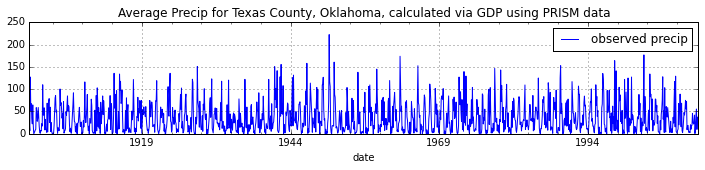

In [65]:
df1.plot(figsize=(12,2),
    title='Average Precip for Texas County, Oklahoma, calculated via GDP using PRISM data ');

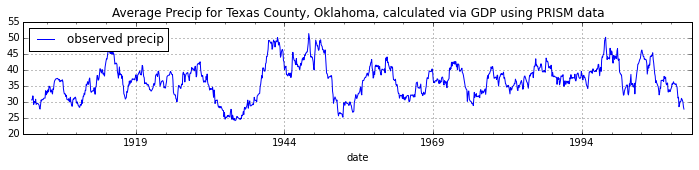

In [66]:
df1 = pd.stats.moments.rolling_mean(df1,36,center=True)
df1.plot(figsize=(12,2),
    title='Average Precip for Texas County, Oklahoma, calculated via GDP using PRISM data ');

In [ ]:
HTML('<iframe src=http://www.ipcc.ch/publications_and_data/ar4/wg1/en/spmsspm-projections-of.html width=900 height=350></iframe>')

In [ ]:
#hayhoe_URI ='dods://cida-eros-thredds1.er.usgs.gov:8082/thredds/dodsC/dcp/conus_grid.w_meta.ncml'
dataset ='dods://cida.usgs.gov/thredds/dodsC/maurer/maurer_brekke_w_meta.ncml'
variable = 'sresa2_gfdl-cm2-1_1_Prcp'
timeRange = myGDP.getTimeRange(dataset, variable)
timeRange

In [67]:
# retrieve the GFDL model A2 more "Business-as-Usual" scenario:
time0=time.time();
name2='sresa2_gfdl-cm2-1_1_Prcp.csv'
if not os.path.exists(name2):
    variable = 'sresa2_gfdl-cm2-1_1_Prcp'
    result2 = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, dataset, variable,
            timeRange[0],timeRange[1],user_attribute,user_value, delim='COMMA', stat='MEAN' )
    f = urllib.urlretrieve(result2,name2)
    print('elapsed time=%d s' % (time.time()-time0))

In [68]:
# now retrieve the GFDL model B1 "Eco-Friendly" scenario:
time0=time.time();
name3='sresb1_gfdl-cm2-1_1_Prcp.csv'
if not os.path.exists(name3):
    variable = 'sresb1_gfdl-cm2-1_1_Prcp'
    result3 = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, dataset, variable,
            timeRange[0],timeRange[1],user_attribute,user_value, delim='COMMA', stat='MEAN' )
    f = urllib.urlretrieve(result3,name3)
    print('elapsed time=%d s' % (time.time()-time0))

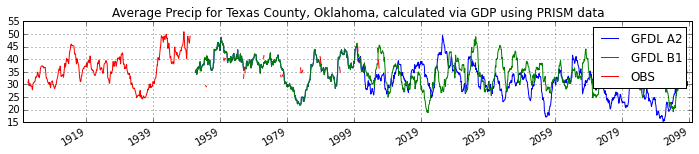

In [69]:
# Load the GDP result for:  "Business-as-Usual" scenario:
# load historical PRISM precip
df2=pd.read_csv(name2,skiprows=3,parse_dates=True,index_col=0,
                names=['date','GFDL A2'])

# Load the GDP result for:   "Eco-Friendly" scenario:
df3=pd.read_csv(name3,skiprows=3,parse_dates=True,index_col=0,
                names=['date','GFDL B1'])
# convert mm/day to mm/month (approximate):


ts_rng = pd.date_range(start='1/1/1900',end='1/1/2100',freq='30D')
ts = pd.DataFrame(index=ts_rng)
df2['GFDL B1'] = df3['GFDL B1']*30.
df2['GFDL A2'] = df2['GFDL A2']*30.
df2 = pd.stats.moments.rolling_mean(df2,36,center=True)
df2 = pd.concat([df2,ts],axis=1).interpolate(limit=1)
df2['OBS'] = pd.concat([df1,ts],axis=1).interpolate(limit=1)['observed precip']

# interpolate 
ax=df2.plot(figsize=(12,2),legend=False,
    title='Average Precip for Texas County, Oklahoma, calculated via GDP using PRISM data ');
ax.legend(loc='upper right');

Now just to show that we can access more than climate model time series, let's extract precipitation data from a dry winter (1936-1937) and a normal winter (2009-2010) for Texas County and look at the spatial patterns.  

We'll use the netCDF4-Python library, which allows us to open OPeNDAP datasets just as if they were local NetCDF files. 

In [76]:
import netCDF4
url='http://cida.usgs.gov/thredds/dodsC/prism'
box = [-102,36.5,-100.95,37]  # Bounding box for Texas County, Oklahoma
box = [-104,36.,-100,39.0]  # Bounding box for larger dust bowl region

In [77]:
# define a mean precipitation function, here hard-wired for the PRISM data
def mean_precip(nc,bbox=None,start=None,stop=None):
    lon=nc.variables['lon'][:]
    lat=nc.variables['lat'][:]
    tindex0=netCDF4.date2index(start,nc.variables['time'],select='nearest')
    tindex1=netCDF4.date2index(stop,nc.variables['time'],select='nearest')
    bi=(lon>=box[0])&(lon<=box[2])
    bj=(lat>=box[1])&(lat<=box[3])
    p=nc.variables['ppt'][tindex0:tindex1,bj,bi]
    latmin=np.min(lat[bj])
    p=np.mean(p,axis=0)
    lon=lon[bi]
    lat=lat[bj]
    return p,lon,lat

In [78]:
nc = netCDF4.Dataset(url)
p,lon,lat = mean_precip(nc,bbox=box,start=datetime.datetime(1936,11,1,0,0),
                        stop=datetime.datetime(1937,4,1,0,0))
p2,lon,lat = mean_precip(nc,bbox=box,start=datetime.datetime(1940,11,1,0,0),
                       stop=datetime.datetime(1941,4,1,0,0))
latmin = np.min(lat)

In [79]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

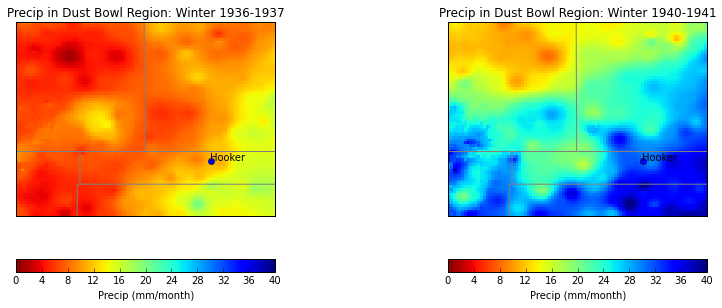

In [80]:
fig = plt.figure(figsize=(12,5)) 
ax = fig.add_axes([0.1, 0.15, 0.3, 0.8],projection=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, p, cmap=plt.cm.jet_r,vmin=0,vmax=40)
plt.title('Precip in Dust Bowl Region: Winter 1936-1937')
ax.add_feature(states_provinces,edgecolor='gray')
ax.text(-101,36.86,'Hooker')
ax.plot(-101,36.86,'o')

cb = plt.colorbar(pc,   orientation='horizontal')
cb.set_label('Precip (mm/month)')

ax2 = fig.add_axes([0.6, 0.15, 0.3, 0.8],projection=ccrs.PlateCarree())
pc2 = ax2.pcolormesh(lon, lat, p2, cmap=plt.cm.jet_r,vmin=0,vmax=40)
plt.title('Precip in Dust Bowl Region: Winter 1940-1941')

ax2.add_feature(states_provinces,edgecolor='gray')
ax2.text(-101,36.86,'Hooker')
ax2.plot(-101,36.86,'o')

cb2 = plt.colorbar(pc2,  orientation='horizontal')
cb2.set_label('Precip (mm/month)')


plt.show()

From the above patterns, we can see that it's significantly drier in the northwestern part of the county in both years.  We can also see that the *maximum* precip in 1936-1937 is less than the *minimum* precipitation in 2009-2010.  We can see just how much each part of the county was drier by doing the different plot below. 

Hopefully this demo inspires other investigation of historical and projected climate data using the GDP and Python.  